In [1]:
import os
import base64
import numpy as np
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data
import random as rand

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib import colors



# 1. Os Local file 경로 설정


In [2]:
address = "./"
address_weather = "./data/weather_data/"
address_data = "./data/"
address_data_pv = "./data/pv_data/"
addr_model = "./model/"

In [3]:
EPS = 1e-5

In [4]:
args = {
    'BATCH_SIZE': 16,
    'LEARNING_RATE': 1e-5,
    'NUM_EPOCH': 1000
}


In [5]:
cd ..


c:\Users\USER\playground\2022


In [6]:
df_sample = pd.read_csv(address_data+'pv_all_values.csv')
df_site_info = pd.read_csv(
    address_data+'data_each_PV_info_20191201_20210814(bell).csv', index_col=0)


In [7]:
class PV_data(data.Dataset):
    def __init__(self, df_pv, df_info, transform):
        self.df_pv = df_pv
        self.df_info = df_info
        self.arr_pv_val = np.expand_dims(
            df_pv.values[:14952-72][:, 3:].T.reshape(-1, 620, 24), 3)
        self.arr_pv_num = df_pv.columns.values[3:]
        self.transform = transform

    def is_bell(self, num):
        bell = self.df_info.loc[int(num)]['bell']
        return bell

    def pv_num(self, idx):
        num = int(self.arr_pv_num[idx])
        return num

    def pv_idx(self, pv_num):
        idx = np.where(self.arr_pv_num == str(pv_num))[0][0]
        return idx

    def value(self, num):
        val = self.df_pv[num].values
        return val

    def __len__(self):
        return len(self.arr_pv_val)
    
    def __getitem__(self, idx):
        img_tensor = self.transform(self.arr_pv_val[idx])
        return img_tensor, self.is_bell(self.pv_num(idx))


In [8]:
class PV_data_3layer(data.Dataset):
    def __init__(self, df_pv, df_info, transform):
        self.df_pv = df_pv
        self.df_info = df_info
        self.arr_pv_val = np.expand_dims(
            df_pv.values[:14952-24*7][:, 3:].T.reshape(-1, 616, 24), 3)
        self.arr_pv_num = df_pv.columns.values[3:]
        self.transform = transform

    def is_bell(self, num):
        bell = self.df_info.loc[int(num)]['bell']
        return bell

    def pv_num(self, idx):
        num = int(self.arr_pv_num[idx])
        return num

    def pv_idx(self, pv_num):
        idx = np.where(self.arr_pv_num == str(pv_num))[0][0]
        return idx

    def value(self, num):
        val = self.df_pv[num].values
        return val

    def __len__(self):
        return len(self.arr_pv_val)
    
    def __getitem__(self, idx):
        img_tensor = self.transform(self.arr_pv_val[idx])
        return img_tensor, self.is_bell(self.pv_num(idx))


In [9]:
class ImageTransform():

    def __init__(self):
        pass

    def __call__(self, img):
        mean = 0
        std = img.max()
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean+EPS, std+EPS)
        ])
        return self.data_transform(img)


In [10]:
def plot_heat(arr):
    plt.pcolor(arr)
    plt.colorbar()
    plt.show()


In [11]:
train_dataset =  PV_data(df_sample, df_site_info, transform=ImageTransform())

train_dataloader = data.DataLoader(
    train_dataset,
    batch_size = args['BATCH_SIZE'],
    shuffle = True
)

# batch_iterator = iter(train_dataloader)
# input_img,a = next(batch_iterator)

# Heatmap으로 Load Profile 시각화


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
class CAE_Network(nn.Module):
    def __init__(self, kernel_size, out_size, hidden_size):
        super(CAE_Network, self).__init__()
        self.k = kernel_size
        self.o = out_size
        self.h = hidden_size

        # Encoder Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.o, self.k, padding=1, stride=1),
            nn.BatchNorm2d(self.o),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.o, (self.o)**2, self.k, padding=1, stride=1),
            nn.BatchNorm2d((self.o)**2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Decoder Layers
        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d((self.o)**2, self.o,
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

        self.trans_conv2 = nn.Sequential(
            nn.ConvTranspose2d(self.o, 1, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        print(x.shape)
        out = self.conv1(x)
        print(out.shape)
        out = self.conv2(out)
        print(out.shape)
        latent = out
        out = self.trans_conv1(out)
        print(out.shape)
        out = self.trans_conv2(out)
        print(out.shape)
        return latent, out

    # def detect(self, x):
    #     out = self.conv1(x)
    #     latent = self.conv2(out)

    #     return latent


In [14]:
class CAE_Network_3layer(nn.Module):
    def __init__(self, kernel_size, out_size, hidden_size):
        super(CAE_Network_3layer, self).__init__()
        self.k = kernel_size
        self.o = out_size
        self.h = hidden_size

        # Encoder Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.o, self.k, padding=1, stride=1),
            nn.BatchNorm2d(self.o),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.o, (self.o)**2, self.k, padding=1, stride=1),
            nn.BatchNorm2d((self.o)**2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d((self.o)**2, (self.o)**3, self.k, padding=1, stride=1),
            nn.BatchNorm2d((self.o)**3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Decoder Layers

        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d((self.o)**3, (self.o)**2,
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
        self.trans_conv2 = nn.Sequential(
            nn.ConvTranspose2d((self.o)**2, self.o,
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

        self.trans_conv3 = nn.Sequential(
            nn.ConvTranspose2d(self.o, 1, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        print(x.shape)
        out = self.conv1(x)
        print(out.shape)
        out = self.conv2(out)
        out = self.conv3(out)
        print(out.shape)
        latent = out
        out = self.trans_conv1(out)
        print(out.shape)
        out = self.trans_conv2(out)
        print(out.shape)
        out = self.trans_conv3(out)
        print(out.shape)
        return latent, out

    # def detect(self, x):
    #     out = self.conv1(x)
    #     latent = self.conv2(out)

    #     return latent


In [19]:
model = CAE_Network(3,3,64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

# model.load_state_dict(torch.load(addr_model+'pv_CAE/CAE_train_all.pt'))

# Model Train

In [20]:
steps = 0
total_steps = len(train_dataloader)
for epoch in range(args['NUM_EPOCH']):
    running_loss = 0
    for i, (X_train,_) in enumerate(train_dataloader):
        steps += 1
        X_train = X_train.to(device).float() ##
        _,output = model(X_train)
        loss = criterion(output, X_train)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()*X_train.shape[0]

        if steps % total_steps == 0:
            model.eval()

            if (epoch+1)%10==0:
                print('Epoch: {}/{}'.format(epoch+1,
                    args['NUM_EPOCH']),  'Training Loss: {:.5f}..'.format(running_loss/total_steps))
            steps = 0
            running_loss = 0
            model.train()


torch.Size([16, 1, 620, 24])
torch.Size([16, 3, 310, 12])
torch.Size([16, 9, 155, 6])
torch.Size([16, 3, 155, 6])
torch.Size([16, 1, 155, 6])


C:\Users\USER\anaconda3\envs\py37\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 620, 24])) that is different to the input size (torch.Size([16, 1, 155, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (6) must match the size of tensor b (24) at non-singleton dimension 3

In [89]:
torch.save(model.state_dict(),addr_model+'pv_CAE/CAE_train_3l_o3.pt')

-----------------1번째 비교----------------


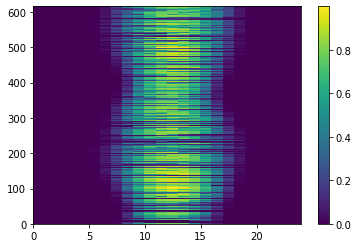

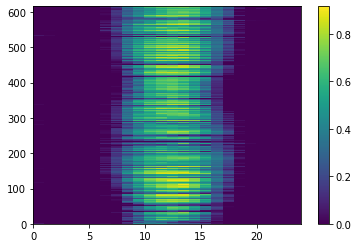

-----------------2번째 비교----------------


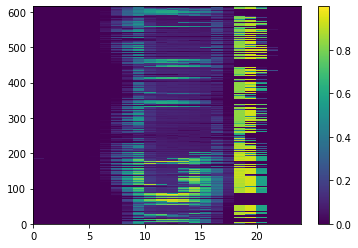

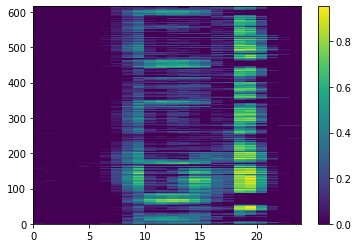

-----------------3번째 비교----------------


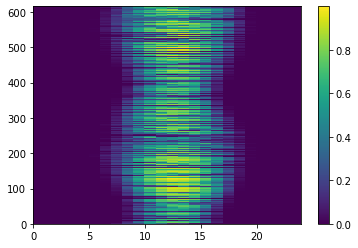

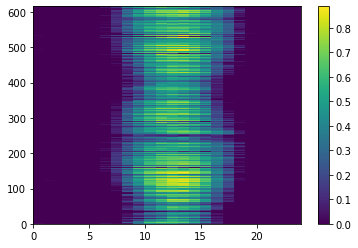

-----------------4번째 비교----------------


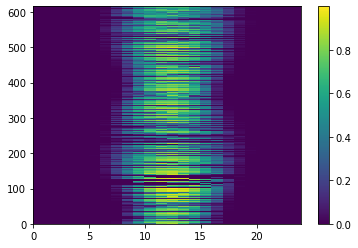

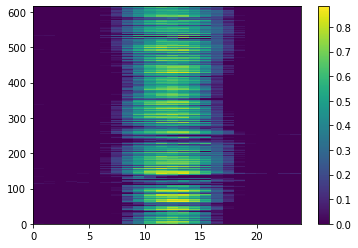

-----------------5번째 비교----------------


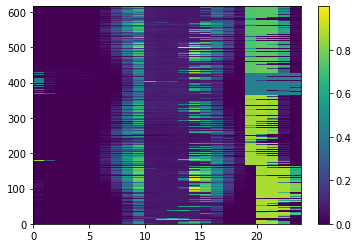

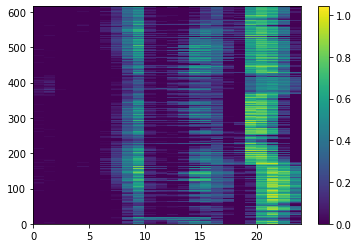

In [90]:
X = X_train.cpu().numpy()
X_bar = output.cpu().detach().numpy()

for i in range(len(X)):
    print('-----------------{}번째 비교----------------'.format(i+1))
    plot_heat(X.squeeze()[i])
    plot_heat(X_bar.squeeze()[i])


# Clustering(Anomaly detection test)

In [18]:
def flatten_avg(arr):
    avg_arr = np.average(arr,axis =1)
    return avg_arr.reshape(len(avg_arr),-1)

def flatten(arr):
    return arr.reshape(len(arr),-1)

In [82]:
def test_CAE(layer = 2, outsize = 3):
    if layer ==2:
        model = CAE_Network(3,outsize,64)
    elif layer ==3:
        model = CAE_Network_3layer(3,outsize,64)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])
    model.load_state_dict(torch.load(addr_model+'pv_CAE/CAE_train_{}l_o{}.pt'.format(layer,outsize)))

    steps = 0
    total_steps = len(train_dataloader)
    model.eval()

    for i, (X_train,isbell) in enumerate(train_dataloader):
        X_train = X_train.float() ##
        latent,_ = model(X_train)
        if i==0:
            latent_isbell = isbell.numpy()
            latent_z = latent.detach().numpy()

        else:
            latent_isbell = np.concatenate((latent_isbell,isbell.numpy()))
            latent_z = np.concatenate((latent_z,latent.detach().numpy()))
            
    return (latent_z , latent_isbell)

In [83]:
def visualize_PCA(vector,bell):
    # PCA로 latent vector transformation(차원축소)
    pca = PCA(n_components = 2)
    pca_Component = pca.fit_transform(flatten_avg(vector))
    pca_bell = [pca_Component[bell], pca_Component[bell ==False]]

    # 
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize=20)

    targets = ["Bell", "Non-Bell"]
    colors = ['b', 'r']

    for i, color in enumerate(colors):
        ax.scatter(pca_bell[i][:,0],pca_bell[i][:,1],c=color,s=50)
        ax.grid()

    ax.legend(targets)
    ax.grid()
    return pca_Component

Accuracy of Anomaly Detection : 97.85%		2517samples


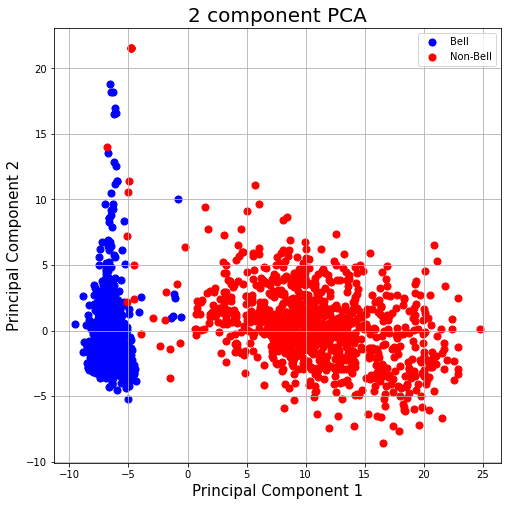

In [25]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 4)
pca_Component = visualize_PCA(latent_z,latent_isbell)

k = 2
c_model = KMeans(n_clusters = 4,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

Accuracy of Anomaly Detection : 99.28%		2517samples


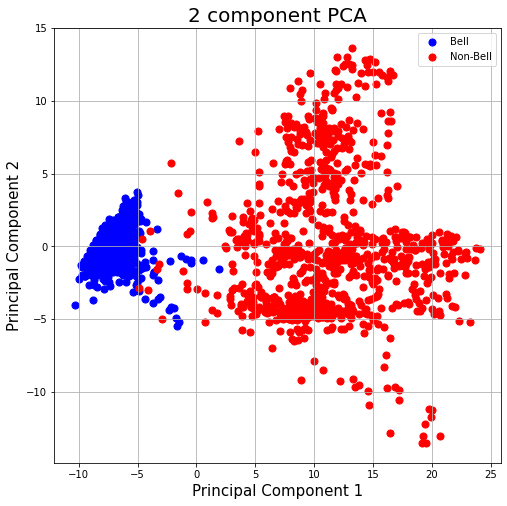

In [ ]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 3)
pca_Component = visualize_PCA(latent_z,latent_isbell)

k = 2
c_model = KMeans(n_clusters = 4,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

Accuracy of Anomaly Detection : 98.57%		2517samples


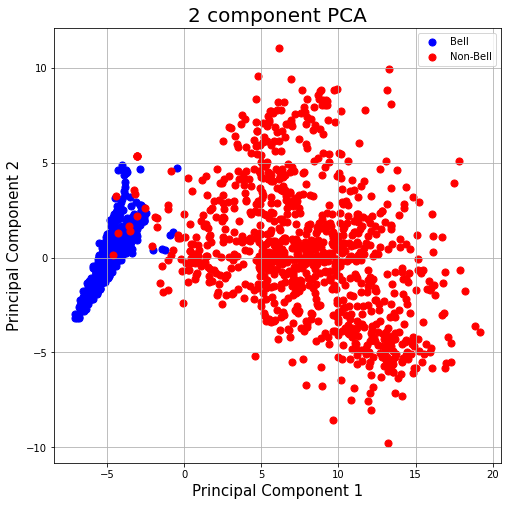

In [ ]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 2)
pca_Component = visualize_PCA(latent_z,latent_isbell)

k = 2
c_model = KMeans(n_clusters = 4,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

Accuracy of Anomaly Detection : 98.37%		2517samples


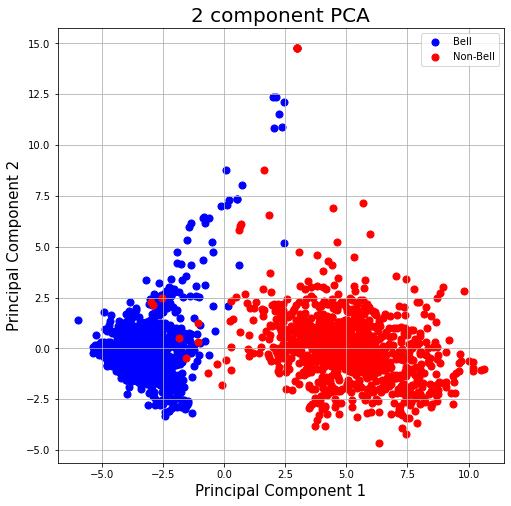

In [86]:
latent_z,latent_isbell = test_CAE(layer = 3,outsize = 2)
pca_Component = visualize_PCA(latent_z,latent_isbell)

k = 2
c_model = KMeans(n_clusters = 4,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

Accuracy of Anomaly Detection : 39.21%		2517samples


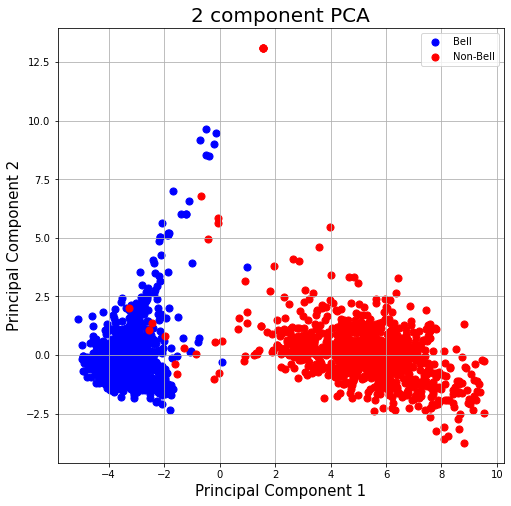

In [91]:
latent_z,latent_isbell = test_CAE(layer = 3,outsize = 3)
pca_Component = visualize_PCA(latent_z,latent_isbell)

k = 2
c_model = KMeans(n_clusters = 4,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))